<a href="https://colab.research.google.com/github/MillenniumForce/DATA3001/blob/main/deep_learning/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install polars[pyarrow]
!pip install backports.weakref

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import polars as pl

In [ ]:
tqdm.pandas()

# Condense features to bytes per packet

In [ ]:
polars_df = pl.scan_csv("/content/drive/MyDrive/DATA3001/datascience-cis-2022.csv", parse_dates=True)

In [ ]:
cols = polars_df.columns
cols.remove("device_mac")
cols.remove("time")
cols

['FromInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount',
 'FromInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount',
 'FromInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
 'FromInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount',
 'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
 'FromInternetTCPPort80IPurn:ietf:params:mud:controllerPacketCount',
 'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
 'FromInternetUDPPort67IPurn:ietf:params:mud:controllerPacketCount',
 'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount',
 'ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketCount',
 'ToInternetTCPPort443IPurn:ietf:params:mud:controllerByteCount',
 'ToInternetTCPPort443IPurn:ietf:params:mud:controllerPacketCount',
 'ToInternetTCPPort554IPurn:ietf:params:mud:controllerByteCount',
 'ToInternetTCPPort554IPurn:ietf:params:mud:controllerPacketCount',
 'ToInternetTCPPort80IPurn:ietf:params:mud:contr

In [ ]:
# Using Polars otherwise Pandas crashes

for byte, packet in zip(cols[::2], cols[1::2]):
  new_col_name = byte.replace("ByteCount", "BytesPerPacket")
  polars_df = polars_df.with_columns([
    (pl.col(byte) / pl.col(packet)).alias(new_col_name)
  ])
  polars_df = polars_df.drop([byte, packet])

polars_df = polars_df.fill_null(0)
# polars_df.collect().write_parquet("/content/drive/MyDrive/DATA3001/bytes_per_packet_features.parquet")

In [ ]:
processed_cols = polars_df.columns

pairs = [
    ("FromInternetTCPPort443IPurn:ietf:params:mud:controllerBytesPerPacket", "ToInternetTCPPort443IPurn:ietf:params:mud:controllerBytesPerPacket"),
    ("FromInternetTCPPort554IPurn:ietf:params:mud:controllerBytesPerPacket", "ToInternetTCPPort554IPurn:ietf:params:mud:controllerBytesPerPacket"),
    ("FromInternetTCPPort80IPurn:ietf:params:mud:controllerBytesPerPacket", "ToInternetTCPPort80IPurn:ietf:params:mud:controllerBytesPerPacket"),
    ("FromInternetUDPPort67IPurn:ietf:params:mud:controllerBytesPerPacket",  "ToLocalUDPPort67IP255.255.255.255/32BytesPerPacket")
]

for col1, col2 in pairs:
  new_col_name = col1.replace("FromInternet", "ToFromDiff")
  polars_df = polars_df.with_columns([
    (pl.col(col1) - pl.col(col2)).alias(new_col_name)
  ])
  polars_df = polars_df.drop([col1, col2])

polars_df.collect().write_parquet("/content/drive/MyDrive/DATA3001/diff_bytes_per_packet_features.parquet")

KeyboardInterrupt: ignored

# Load Features

In [5]:
df = pd.read_parquet("/content/drive/MyDrive/DATA3001/diff_bytes_per_packet_features.parquet")
df.time = pd.to_datetime(df.time, unit="ns")
df = df.set_index("time")

In [6]:
print(df.shape)
df.head(5)

(14376698, 8)


,device_mac,ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerBytesPerPacket,ToInternetUDPPort1024IPurn:ietf:params:mud:controllerBytesPerPacket,ToLocalUDPPort5353IP224.0.0.251/32BytesPerPacket,ToFromDiffTCPPort443IPurn:ietf:params:mud:controllerBytesPerPacket,ToFromDiffTCPPort554IPurn:ietf:params:mud:controllerBytesPerPacket,ToFromDiffTCPPort80IPurn:ietf:params:mud:controllerBytesPerPacket,ToFromDiffUDPPort67IPurn:ietf:params:mud:controllerBytesPerPacket
time,,,,,,,,
2022-09-02 00:24:59.417,bd:0d:8e:c5,446,1388,0,0,0,-413,0
2022-09-02 00:24:59.417,bd:24:bb:1e,446,0,0,0,-1304,-188,0
2022-09-02 00:24:59.417,bd:0d:af:0b,446,0,0,0,0,-143,0
2022-09-02 00:24:59.417,ee:dd:34:1d,446,0,0,0,0,-365,0
2022-09-02 00:24:59.417,ee:dd:39:08,446,0,0,0,-1321,0,-103


# Feature generation

features = time steps over $k$ window size (resample)

outcome = Y/N if the data belongs to the chosen network flow

In [ ]:
chosen_flow = "FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount"
window_size = 60 #i.e. 1 hour (use pca later?)

sample = df[["device_mac", "FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount"]]
sample

,device_mac,FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount
time,,
2022-09-02 00:24:59.417,bd:0d:8e:c5,0
2022-09-02 00:24:59.417,bd:24:bb:1e,71161
2022-09-02 00:24:59.417,bd:0d:af:0b,25880
2022-09-02 00:24:59.417,ee:dd:34:1d,0
2022-09-02 00:24:59.417,ee:dd:39:08,0
...,...,...
2022-09-16 00:23:55.620,bd:1c:cf:14,0
2022-09-16 00:23:55.620,21:fa:29:50,1934
2022-09-16 00:23:55.620,ee:dd:49:33,74945


In [ ]:
sample = sample.groupby("device_mac").resample("1min").sum().unstack()

In [ ]:
sample

In [ ]:
sample.columns = sample.columns.droplevel()

In [ ]:
sample.columns = np.arange(0, len(sample.columns))

In [ ]:
sample

,0,1,2,3,4,5,6,7,8,9,...,20150,20151,20152,20153,20154,20155,20156,20157,20158,20159
device_mac,,,,,,,,,,,,,,,,,,,,,
21:fa:27:56,967.0,967.0,967.0,967.0,0.0,967.0,967.0,967.0,967.0,967.0,...,967.0,967.0,967.0,967.0,967.0,2468.0,967.0,967.0,967.0,NaN
21:fa:27:82,71991.0,71310.0,78759.0,70941.0,72726.0,71035.0,75039.0,76382.0,72848.0,75039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21:fa:29:50,967.0,2887.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,967.0,...,1934.0,1934.0,1934.0,7386.0,3854.0,3854.0,3854.0,1934.0,1934.0,1934.0
21:fa:2d:cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21:fa:2e:47,45199.0,49109.0,49391.0,45387.0,50631.0,46433.0,50605.0,45387.0,49203.0,49297.0,...,72754.0,74945.0,70663.0,69121.0,74945.0,70941.0,72726.0,70941.0,74945.0,70941.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee:dd:4e:5f,46556.0,48867.0,46838.0,48676.0,44787.0,53547.0,47375.0,46363.0,46826.0,43661.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ee:dd:4e:60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ee:dd:4f:4c,76456.0,70402.0,73066.0,74976.0,76817.0,72249.0,76955.0,71161.0,76788.0,78879.0,...,25905.0,25905.0,25905.0,25905.0,25905.0,25905.0,25905.0,0.0,25905.0,25905.0


In [ ]:
sample.iloc[:, 60:60 + window_size]

In [ ]:
batches = []

for i in range(0, len(sample.columns) - window_size, window_size):
  batches.append(sample.iloc[:, i:i+window_size].to_numpy())
  # print(i, i + window_size)

batches = np.concatenate(batches)

In [ ]:
batches = pd.DataFrame(batches)
batches["flow_type"] = chosen_flow

In [ ]:
batches

In [ ]:
# Total number of rows to expect
252255 * 22

5549610

# Split data train, val, test (0.6, 0.2, 0.2)

In [7]:
n = len(df)
train_df = df[0:int(n*0.6)]
val_df = df[int(n*0.6):int(n*0.8)]
test_df = df[int(n*0.8):]

In [8]:
del df

In [10]:
cols = train_df.columns.to_list()
cols.remove("device_mac")
cols

['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerBytesPerPacket',
 'ToInternetUDPPort1024IPurn:ietf:params:mud:controllerBytesPerPacket',
 'ToLocalUDPPort5353IP224.0.0.251/32BytesPerPacket',
 'ToFromDiffTCPPort443IPurn:ietf:params:mud:controllerBytesPerPacket',
 'ToFromDiffTCPPort554IPurn:ietf:params:mud:controllerBytesPerPacket',
 'ToFromDiffTCPPort80IPurn:ietf:params:mud:controllerBytesPerPacket',
 'ToFromDiffUDPPort67IPurn:ietf:params:mud:controllerBytesPerPacket']

In [11]:
# from sklearn.preprocessing import MinMaxScaler

# def process(X):
#   scaler = MinMaxScaler()
#   X[cols] = scaler.fit_transform(X[cols])
#   return X

# test_df.groupby("device_mac").progress_apply(process)


# Bulk compute all features

In [13]:
DEVICE_MAC = "device_mac"


def construct_flow_dataframe(df, flow_type, window_size=5):
  flow_df = df[[DEVICE_MAC, flow_type]]

  # Resample to 1 minute to ensure that any time discrepencies are accounted for
  flow_df.index = flow_df.index.round("min")

  # Pivot to set time as columns
  flow_df = flow_df.reset_index() \
                   .pivot(index=DEVICE_MAC, values=flow_type, columns="time")

  # Linear interploation to fill nans
  flow_df = flow_df.interpolate(axis="columns", limit_direction="both")

  # Replace timestamps with ints for easy indexing of windows
  flow_df.columns = np.arange(0, len(flow_df.columns))

  # Using a rolling window type scheme to extract data
  # For a 60min rolling window each batch with contain 60 minutes each
  # independent from each other (this is to avoid huge amounts of data
  # from a rolling window of 0-59, 1-60, 2-61 etc. use instead 0-59, 60-119...)
  batches = []
  for i in range(0, len(flow_df.columns) - window_size, window_size):
    batches.append(flow_df.iloc[:, i:i+window_size].to_numpy())
    # print(i, i + window_size)
  batches = np.concatenate(batches)

  # Construct final dataframe
  flow_df = pd.DataFrame(batches)
  flow_df["flow_type"] = flow_type

  # ensure cleanup for memory efficiency
  del batches

  return flow_df


In [14]:
construct_flow_dataframe(train_df, "ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerBytesPerPacket")

,0,1,2,3,4,flow_type
0,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
1,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
2,450.0,378.0,378.0,450.0,450.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
3,0.0,0.0,0.0,0.0,0.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
4,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
...,...,...,...,...,...,...
1750720,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
1750721,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
1750722,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
1750723,290.0,293.0,286.0,300.0,293.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...


In [15]:
from multiprocessing import Pool
from tqdm.notebook import tqdm

In [16]:
from multiprocessing import cpu_count

In [17]:
cpu_count()

2

In [27]:
flow_datasets = [construct_flow_dataframe(test_df, col) for col in tqdm(cols)]

  0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
from functools import partial
from tqdm.contrib.concurrent import process_map

flow_datasets = process_map(partial(construct_flow_dataframe, train_df), 
                            cols,
                            max_workers=1, 
                            chunksize=5)

  0%|          | 0/7 [00:01<?, ?it/s]

BrokenProcessPool: ignored

In [28]:
fld = pd.concat(flow_datasets, axis=0)
fld.columns = fld.columns.astype(str)
fld.to_parquet("/content/drive/MyDrive/DATA3001/5_min_bytes_per_packet_feats_diff/test.parquet")

In [29]:
fld.isna().sum().any()

False

In [30]:
fld

,0,1,2,3,4,flow_type
0,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
1,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
2,450.0,378.0,450.0,390.0,450.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
3,0.0,0.0,0.0,0.0,0.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
4,446.0,446.0,446.0,446.0,446.0,ToInternetRSVPPortAllIPurn:ietf:params:mud:con...
...,...,...,...,...,...,...
583570,0.0,0.0,0.0,0.0,0.0,ToFromDiffUDPPort67IPurn:ietf:params:mud:contr...
583571,0.0,-103.0,-103.0,-103.0,0.0,ToFromDiffUDPPort67IPurn:ietf:params:mud:contr...
583572,0.0,-103.0,-103.0,-103.0,0.0,ToFromDiffUDPPort67IPurn:ietf:params:mud:contr...
583573,-103.0,-103.0,-103.0,0.0,0.0,ToFromDiffUDPPort67IPurn:ietf:params:mud:contr...


# Inspect data

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/COMP3001/flow_dataset_60_min.parquet")

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,flow_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FromInternetTCPPort443IPurn:ietf:params:mud:co...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252250,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,ToLocalUDPPort67IP255.255.255.255/32PacketCount
252251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ToLocalUDPPort67IP255.255.255.255/32PacketCount
252252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ToLocalUDPPort67IP255.255.255.255/32PacketCount
252253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,ToLocalUDPPort67IP255.255.255.255/32PacketCount


In [ ]:
df.flow_type.nunique()

22

In [ ]:
import matplotlib.pyplot as plt

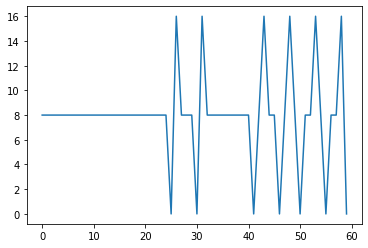

In [ ]:
plt.plot(df.loc[df.flow_type == "ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerPacketCount"].iloc[7].to_list()[:-1])